A good explanation of PCA and SVD usage: http://nicolas-hug.com/blog/matrix_facto_1

#########################################################################################################################

## Applications:

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Importing dataset: Movies

ratings="https://github.com/qcrochard/tutorials/raw/master/recommender_system/data/ratings.csv"
movies="https://github.com/qcrochard/tutorials/raw/master/recommender_system/data/movies.csv"
df_ratings = pd.read_csv(ratings, sep=',')
df_ratings.columns = ['userId', 'itemId', 'rating', 'timestamp']
df_movies = pd.read_csv(movies, sep=',')
df_movies.columns = ['itemId', 'title', 'genres']

In [3]:
# Creating Movies sample:

sample1 = {'2628':'Star Wars I',           # sci-fi
           '5669':'Bowling for Columbine', # documentary
           '4973':'Amelie',                # love
           '5618':'Spirited Away',         # animation
           '1201':'Good, Bad and Ugly'}    # western
sample_itemId = [x for x in sample1.keys()]
sample_title = [x for x in sample1.values()]

# df_ratings for sample1
df_ratings_sample = df_ratings[df_ratings.itemId.isin(sample_itemId)].dropna() 
df_ratings_sample['title'] = df_ratings_sample['itemId']
df_ratings_sample['title'] = df_ratings_sample['title'].astype(str).apply(lambda x: sample1[x])

# pivot tables: of user reviews vs movies (for sample1)
df_user_item = df_ratings_sample.pivot(index = 'userId', columns ='title', values = 'rating').dropna()
df_user_item.index = ['Paul','Luc','Joe','Zoe','Kate','Dan','Aly','Eva','John']
df_user_item

title,Amelie,Bowling for Columbine,"Good, Bad and Ugly",Spirited Away,Star Wars I
Paul,2.0,3.5,3.5,2.5,3.0
Luc,5.0,3.0,5.0,4.0,3.5
Joe,5.0,4.0,5.0,5.0,4.0
Zoe,5.0,4.0,3.5,4.5,4.0
Kate,5.0,4.0,4.0,4.0,1.0
Dan,4.0,4.0,4.0,4.0,4.0
Aly,5.0,4.5,3.5,2.5,3.0
Eva,4.5,4.0,4.0,4.5,3.5
John,4.0,4.0,5.0,4.0,3.0


#########################################################################################################################

## PCA:

Algorithm revealing principal components.

We're looking for movies / user correlations.
Correlation not between the actual people and movies in the matrix but between:
- typical movies (eigenmovies, Principal Components, e.g. Action movies, Romance movies, etc.)
- and typical users (eigenusers, Principal Components, e.g. Action fan, Comedy fan, etc.)

In practice, the concepts that PCA reveals are really not that always clear, but the important fact remains: each of vector captures a specific aspect of the data. We call these aspects the latent factors (latent, because they were there all the time, we just needed PCA to reveal them).

So to sum up: PCA reveals main aspects of the data, and from these vectors can rebuild the original data.

#### PCA Factorization: 
X can be rebuild from 2 matrices P and H via
\begin{equation}
X = P.H
\end{equation}
where: 
- $X$ can be any matrix of size *(m x n)*
- $H$ est le projeté des observations de X dans la base des features principales
- The covariance matrix of X's features $X.X^{T}$ being symetrical, can be diagonalised: $X.X^{T}=P.D.P^{-1}$. 
    - $P$ is the eigen-vectors matrix of $X.X^{T}$ which is the covariance matrix of X's *m* features.
    - $D$ contains the diagonal eigen values.
    - $P$ being orthogonal $P^{-1}$ = $P^{t}$
- Same thing with covariance matrix of X's lines $X^{T}.X$

And if:
- $X$ lines contain users, using PCA: $X = P_{1} V$, then $V$ will give the typical users. It represents how much users "like" each PC features (action, romance, etc).
- $X^{t}$ lines contain movies, using PCA: $X^{t} = P_{2} U$, then $U$ will give the typical movies. It represents how relevant each PC feature (action, romance, etc) is to each movie.


Note: PCA is an analysis of variances, so it's always good to standardise the data beforehand. Pour avoir des ordres de grandeurs comparables entre variables.

#### PCA on users_movies :

In [128]:
X = df_user_item

# scaling data:
from sklearn.preprocessing import StandardScaler
X_s = StandardScaler().fit_transform(X)
X_s = pd.DataFrame(X_s, index=X.index, columns=X.columns)

#### Manual PCA: to find typical movies: $𝑋^{𝑡}=𝑃_{2}𝑈$

In [129]:
# Matrice des covariance des films:
X_s.T.dot(X_s)

title,Amelie,Bowling for Columbine,"Good, Bad and Ugly",Spirited Away,Star Wars I
title,,,,,
Amelie,9.000000,2.416842,2.426433,4.804926,-0.033509
Bowling for Columbine,2.416842,9.000000,-3.401680,-0.349663,-0.798621
"Good, Bad and Ugly",2.426433,-3.401680,9.000000,4.790806,1.207401
Spirited Away,4.804926,-0.349663,4.790806,9.000000,2.753696
Star Wars I,-0.033509,-0.798621,1.207401,2.753696,9.000000


In [144]:
# Coordinates in PC_movies base:

eigenvalues, P2 = np.linalg.eig(X_s.T.dot(X_s))
P2 = pd.DataFrame(P2, index=X.columns, columns=['PC%d'%x for x in range(1,X.shape[1]+1)])
# D = pd.DataFrame(np.diag(eigenvalues))
U = P2.T.dot(X_s.T) # U.T = projection des users dans la base de "PC typical movies"

In [145]:
# Sklearn PCA verification:
#  note: sklearn fitted with X.T returns P1 and V
#        sklearn fitted with X returns P2 and U

from sklearn.decomposition import PCA
pca = PCA().fit(X_s)
X_PCmovies = pd.DataFrame(pca.transform(X_s), index=X.index)  
P2_sklearn = pd.DataFrame(pca.components_.T, index=X.columns) 

display(X_PCmovies.T,U)
display(P2_sklearn,P2)

,Paul,Luc,Joe,Zoe,Kate,Dan,Aly,Eva,John
0,2.753561,-1.515663,-2.101736,-0.387581,0.506949,0.041262,1.660374,-0.430807,-0.526359
1,1.972112,1.791075,-0.169949,-0.791324,-1.161350,0.091623,-1.678132,-0.384253,0.330199
2,-0.242040,0.791818,-0.397240,-1.123191,2.210456,-1.025536,-0.251833,-0.460306,0.497871
3,0.135647,-0.926450,0.588047,-0.847155,-0.183920,0.186688,-0.104610,-0.048763,1.200515
4,-0.310192,0.677196,0.021038,-0.485467,-0.608190,-0.133462,1.163051,-0.535900,0.211926


,Paul,Luc,Joe,Zoe,Kate,Dan,Aly,Eva,John
PC1,2.753561,-1.515663,-2.101736,-0.387581,0.506949,0.041262,1.660374,-0.430807,-0.526359
PC2,1.972112,1.791075,-0.169949,-0.791324,-1.161350,0.091623,-1.678132,-0.384253,0.330199
PC3,-0.242040,0.791818,-0.397240,-1.123191,2.210456,-1.025536,-0.251833,-0.460306,0.497871
PC4,-0.310192,0.677196,0.021038,-0.485467,-0.608190,-0.133462,1.163051,-0.535900,0.211926
PC5,-0.135647,0.926450,-0.588047,0.847155,0.183920,-0.186688,0.104610,0.048763,-1.200515


,0,1,2,3,4
title,,,,,
Amelie,-0.450490,-0.538869,0.185035,-0.545787,0.417800
Bowling for Columbine,0.137620,-0.755639,-0.236764,0.592640,0.052829
"Good, Bad and Ugly",-0.550797,0.289590,0.318429,0.588091,0.406832
Spirited Away,-0.629800,-0.121645,-0.064682,0.033386,-0.763712
Star Wars I,-0.279452,0.199927,-0.896730,-0.062672,0.271815


,PC1,PC2,PC3,PC4,PC5
title,,,,,
Amelie,-0.450490,-0.538869,0.185035,0.417800,0.545787
Bowling for Columbine,0.137620,-0.755639,-0.236764,0.052829,-0.592640
"Good, Bad and Ugly",-0.550797,0.289590,0.318429,0.406832,-0.588091
Spirited Away,-0.629800,-0.121645,-0.064682,-0.763712,-0.033386
Star Wars I,-0.279452,0.199927,-0.896730,0.271815,0.062672


#### Quick PCA: to find typical users: $𝑋=𝑃_{1}V$ 
to compare with SVD below.

In [146]:
# Matrice des covariance des users:
R = X_s.dot(X_s.T)

eigenvalues, P1 = np.linalg.eig(R)
P1 = pd.DataFrame(P1, index=X.index, columns=['PC%d'%x for x in range(1,X.shape[0]+1)])
V = P1.T.dot(X_s) # PC_users vs movies

#########################################################################################################################

## SVD:

Instead of using PCA twice:
- once on $X$ to get the typical PC users matrix $V$
- and then on $X^{t}$ for typical PC movies matrix $U$

Using SVD we can find those 2 matrix $V$ and $U$ in one step. Basically SVD is PCA on $X$ and $X^{t}$, in one shot.
#### SVD Factorization:
Into 3 matrices:
$$\begin{equation}
X = U\Sigma V^{T}
\end{equation}$$
where: 
- $X$ can be any matrix of size (m x n) 
- The columns of U are orthogonal, as well as the columns of V. Principal components are always orthogonal.
- $Σ$ is a diagonal matrix

Note:
- The columns of U can build back all of the columns of X)
- The columns of V can build back all of the rows of X)

#### SVD on users_movies

In [169]:
X_s.shape

(9, 5)

In [183]:
# SVD = 2 PCA in one step:

U, S, Vh = np.linalg.svd(X_s)
U = pd.DataFrame(U)
S = np.diag(S)
V = pd.DataFrame(Vh.T, index=X.columns)

display(P2,V) # U is the eigenvectors of Xt.X
display(P1,U) # V is the eigenvectors of X.Xt

,PC1,PC2,PC3,PC4,PC5
title,,,,,
Amelie,-0.450490,-0.538869,0.185035,0.417800,0.545787
Bowling for Columbine,0.137620,-0.755639,-0.236764,0.052829,-0.592640
"Good, Bad and Ugly",-0.550797,0.289590,0.318429,0.406832,-0.588091
Spirited Away,-0.629800,-0.121645,-0.064682,-0.763712,-0.033386
Star Wars I,-0.279452,0.199927,-0.896730,0.271815,0.062672


,0,1,2,3,4
title,,,,,
Amelie,0.450490,-0.538869,0.185035,-0.545787,0.417800
Bowling for Columbine,-0.137620,-0.755639,-0.236764,0.592640,0.052829
"Good, Bad and Ugly",0.550797,0.289590,0.318429,0.588091,0.406832
Spirited Away,0.629800,-0.121645,-0.064682,0.033386,-0.763712
Star Wars I,0.279452,0.199927,-0.896730,-0.062672,0.271815


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Paul,(0.6503762803091929+0j),(-0.5650266644613386+0j),(0.0826988223082852+0j),(-0.18331032799977254+0j),(0.07288827795694626+0j),(-0.2864564024171934+0.03333795899456489j),(-0.2864564024171934-0.03333795899456489j),(0.14311010844153002+0.1154443753247365j),(0.14311010844153002-0.1154443753247365j)
Luc,(-0.35799152383298616+0j),(-0.5131578930063296+0j),(-0.27054419216882725+0j),(0.4001945266051409+0j),(-0.4978169381114646+0j),(-0.1026520561052791+0.0573165418019815j),(-0.1026520561052791-0.0573165418019815j),(0.014597517801501033+0.08857555069116858j),(0.014597517801501033-0.08857555069116858j)
Joe,(-0.4964186531397444+0j),(0.048691921095642014+0j),(0.1357266712881896+0j),(0.012432491822727413+0j),(0.31598010254332903+0j),(-0.6575151620109404+0j),(-0.6575151620109404-0j),(-0.00721669135399605+0.05375984328517077j),(-0.00721669135399605-0.05375984328517077j)
Zoe,(-0.09154461633454554+0j),(0.22672104370999405+0j),(0.38376592784439+0j),(-0.28689071154833445+0j),(-0.4552086187960476+0j),(0.082781397245725-0.001054045025743685j),(0.082781397245725+0.001054045025743685j),(0.4054720657673555+0.3354559150023406j),(0.4054720657673555-0.3354559150023406j)
Kate,(0.11973870941850429+0j),(0.3327363963445009+0j),(-0.7552565285590773+0j),(-0.35941458340934207+0j),(-0.09882698344359554+0j),(-0.3215083590291861+0.014409303547381222j),(-0.3215083590291861-0.014409303547381222j),(-0.11564666655154765+0.08993189118846136j),(-0.11564666655154765-0.08993189118846136j)
Dan,(0.009745931167740151+0j),(-0.02625075804473746+0j),(0.35039947235991503+0j),(-0.0788706215898216+0j),(0.10031452331588658+0j),(-0.3935093616121579-0.0031977543131883777j),(-0.3935093616121579+0.0031977543131883777j),(-0.62335962044344+0j),(-0.62335962044344-0j)
Aly,(0.39217131594454097+0j),(0.4807990042117761+0j),(0.08604485900155452+0j),(0.687314430986664+0j),(-0.05621072844936937+0j),(-0.18250939844409161+0.05861157947525885j),(-0.18250939844409161-0.05861157947525885j),(0.07527468298680645+0.07785823386789126j),(0.07527468298680645-0.07785823386789126j)
Eva,(-0.10175424314196868+0j),(0.11009163929498174+0j),(0.15727492003316823+0j),(-0.3166944832134121+0j),(-0.026202043633574958+0j),(0.134602640375961+0.18754319731194577j),(0.134602640375961-0.18754319731194577j),(0.16708523016792015-0.07780501683398139j),(0.16708523016792015+0.07780501683398139j)
John,(-0.12432320039073284+0j),(-0.0946046891444874+0j),(-0.17010995210759802+0j),(0.12523927834614623+0j),(0.6450824086178915+0j),(0.335136679170694+0.055150802262510415j),(0.335136679170694-0.055150802262510415j),(0.37732044794363484+0.2830968002505317j),(0.37732044794363484-0.2830968002505317j)


,0,1,2,3,4,5,6,7,8
0,-0.650376,0.565027,-0.082699,0.072888,-0.183310,-0.094785,0.435267,0.012185,-0.115806
1,0.357992,0.513158,0.270544,-0.497817,0.400195,0.174259,0.238416,0.157868,0.123322
2,0.496419,-0.048692,-0.135727,0.315980,0.012432,-0.098769,0.570393,-0.103950,-0.535601
3,0.091545,-0.226721,-0.383766,-0.455209,-0.286891,-0.156629,0.409605,-0.322393,0.455163
4,-0.119739,-0.332736,0.755257,-0.098827,-0.359415,0.258874,0.305808,-0.049276,-0.051267
5,-0.009746,0.026251,-0.350399,0.100315,-0.078871,0.925171,0.042331,-0.045752,0.018078
6,-0.392171,-0.480799,-0.086045,-0.056211,0.687314,0.035513,0.320175,0.167689,-0.013296
7,0.101754,-0.110092,-0.157275,-0.026202,-0.316694,-0.041869,0.124009,0.909681,0.084599
8,0.124323,0.094605,0.170110,0.645082,0.125239,-0.019776,0.217657,-0.005004,0.683410


#########################################################################################################################

In [15]:
# A more visual example of PCs, using MNIST faces: 400 images

In [16]:
# Loading dataset:

from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces()
X_face = pd.DataFrame(dataset.data)
y_face = pd.Series(dataset.target)
imges = dataset.images # X_face = imges.reshape(400,64*64)

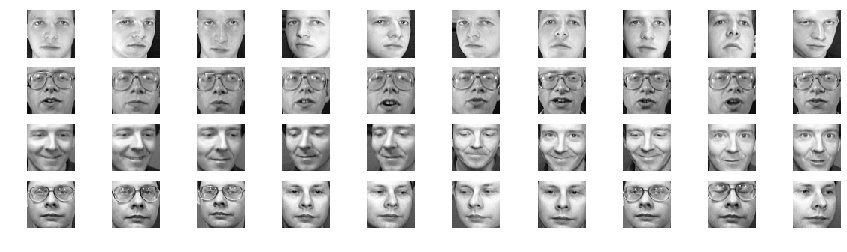

In [17]:
# Showing first 40 images: each person has 10 pictures

plt.subplots(figsize=(15,4))
for i in range(40):
    plt.subplot(4,10,i+1)
    plt.imshow(imges[i], cmap=plt.cm.gray) # showing image no. 10, 20, 30, 40, 50, etc.
    plt.axis('off')
plt.show()

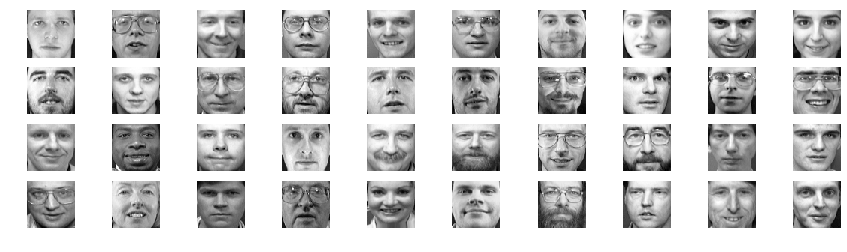

In [18]:
# Showing Faces of all 40 people of the experiment:

plt.subplots(figsize=(15,4))
for i in range(40):
    plt.subplot(4,10,i+1)
    plt.imshow(imges[i*10], cmap=plt.cm.gray) # showing image no. 0, 10, 20, 30, 40, 50, etc.
    plt.axis('off')
plt.show()

C:\Users\Fox\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Fox\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


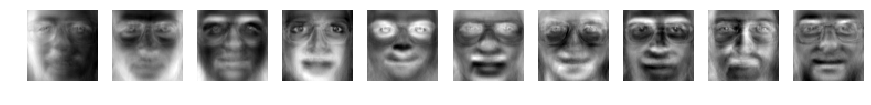

In [207]:
# Showing principal components (typical)) faces:

X = X_face

# Scaling data:
from sklearn.preprocessing import StandardScaler
X_s = StandardScaler().fit_transform(X)
X_s = pd.DataFrame(X_s, index=X.index, columns=X.columns)

# PCA: getting PC_faces base
from sklearn.decomposition import PCA
pca = PCA(n_components=10).fit(X_s.T)    # getting 10 principal aspects of faces
W = pd.DataFrame(pca.components_.T, )    # faces in PC_faces
H = pd.DataFrame(pca.transform(X_s.T))   # pixels in PC_faces

# Plot
plt.subplots(figsize=(15,4))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(H[i].values.reshape(64,64), cmap=plt.cm.gray) # showing image no. 0, 10, 20, 30, 40, 50, etc.
    plt.axis('off')
plt.show()